In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from copy import deepcopy
import random

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 200,200

random.seed(42)

RDKit WARNING: [18:07:31] Enabling RDKit 2019.09.1 jupyter extensions


In [2]:
import py3Dmol

def drawit(m,dimensions=(500,300),p=None,confId=-1):
    mb = Chem.MolToMolBlock(m,confId=confId)
    if p is None:
        p = py3Dmol.view(width=dimensions[0],height=dimensions[1])
    p.removeAllModels()
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()

In [3]:
#smi_file='NIST_Si_100.txt'
smi_file='NIST_Si_all.txt'
mols={}
with open(smi_file) as f:
    for smi in f:
        m = Chem.MolFromSmiles(smi)
        if m: mols[smi.rstrip()] = m

In [4]:
SiMe1=Chem.MolFromSmarts('[Si][CH3]')
SiMe2=Chem.MolFromSmarts('[Si]([CH3])[CH3]')
SiMe3=Chem.MolFromSmarts('[Si]([CH3])([CH3])[CH3]')
ONSSi=Chem.MolFromSmarts('[O,N,S][Si]([CH3])([CH3])[CH3]')

print('# total',len(mols))
with_sime1 = list(filter(lambda m: m.HasSubstructMatch(SiMe1),mols.values()))
print("# with SiMe:", len(with_sime1))
with_sime2 = list(filter(lambda m: m.HasSubstructMatch(SiMe2),mols.values()))
print("# with SiMe2:", len(with_sime2))
with_sime3 = list(filter(lambda m: m.HasSubstructMatch(SiMe3),mols.values()))
print("# with SiMe3:", len(with_sime3))
with_onssi = list(filter(lambda m: m.HasSubstructMatch(ONSSi),mols.values()))
print("# with ONSSi:", len(with_onssi))

MeOX=Chem.MolFromSmarts('C=NO[CH3]')
with_meox = list(filter(lambda m: m.HasSubstructMatch(MeOX),mols.values()))
print("# with MeOX:", len(with_meox))




# total 16510
# with SiMe: 13533
# with SiMe2: 12491
# with SiMe3: 7098
# with ONSSi: 5919
# with MeOX: 254


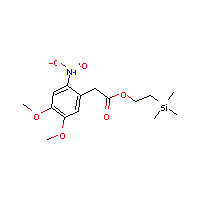

In [12]:
with_sime2[7000]

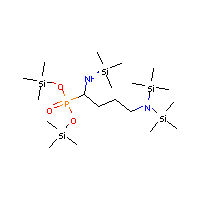

In [20]:
with_onssi[5230]

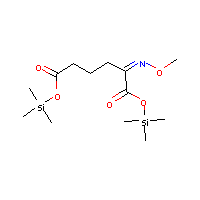

In [27]:
with_meox[42]

In [29]:
with open('NIST_ONSSiMe3.txt','w') as f:
    for m in with_onssi:
        f.write(Chem.MolToSmiles(m)+'\n')
        
with open('NIST_SiMe3.txt','w') as f:
    for m in with_sime3:
        f.write(Chem.MolToSmiles(m)+'\n')
        
with open('NIST_MeOX.txt','w') as f:
    for m in with_meox:
        f.write(Chem.MolToSmiles(m)+'\n')

In [101]:
tms = '[Si]([CH3])([CH3])[CH3]'

# XXX: ~[O,N,S] would match more than we aim to (-O, -S, -N, =N) but it's unlikely to happen
tms_match = Chem.MolFromSmarts('*~[O,N,S]' + tms)
tms_match0 = Chem.MolFromSmarts('[#0]([CH3])([CH3])[CH3]')

def is_derivatized(m):
    return m.HasSubstructMatch(tms_match)

def remove_derivatization_groups(m):
    em = deepcopy(m)
    matches = em.GetSubstructMatches(tms_match)
    for ma in matches:
        em.GetAtomWithIdx(ma[2]).SetAtomicNum(0)
    
    return AllChem.DeleteSubstructs(em,tms_match0)

_subs = [
 ('[OH]', [100], [.95]),
 ('[SH]', [101], [.80]),
# matches also imine
 ('[NH]', [102], [.50]),
 ('[NH2]', [103,102], [.25, .5]),  
]

_repls = {
    100: 'O'+tms,
    101: 'S'+tms,
    102: 'N'+tms,
    103: f'N({tms}){tms}',
}

subs=[]
for pat,repls,probs in _subs:
    spat = Chem.MolFromSmarts(pat)
    subs.append((spat,repls,probs))

repls = list(zip(
    map(lambda n: Chem.MolFromSmarts(f'[#{n}]'),_repls),
    map(Chem.MolFromSmiles,_repls.values())
))


def add_derivatization_groups(m):
    em = deepcopy(m)
    
    n = 200
    for pat,reps,probs in subs:
        matches = em.GetSubstructMatches(pat)
#        print(matches)
        for m in matches:
            r = random.random()
            for repl,prob in zip(reps,probs):
                if r < prob: 
                    em.GetAtomWithIdx(m[0]).SetAtomicNum(repl)
                    break
    
    for pat,repl in repls:
#       print(Chem.MolToSmiles(pat),Chem.MolToSmiles(repl),Chem.MolToSmiles(em))
        em, = AllChem.ReplaceSubstructs(em,pat,repl)
        
    Chem.SanitizeMol(em)
    return em    

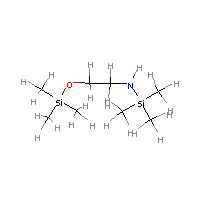

In [102]:
#test_smi='CCO[Si](C)(C)C'
test_smi='C[Si](C)(C)OCC-N[Si](C)(C)C'
test_m = Chem.MolFromSmiles(test_smi)
Chem.AddHs(test_m)

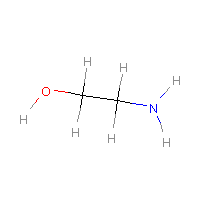

In [103]:
test_n = remove_derivatization_groups(test_m)
Chem.AddHs(test_n)

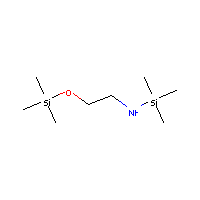

In [118]:
add_derivatization_groups(test_n)

In [ ]:
print("# total:", len(mols))
#print("# derivatized:", sum(map(is_derivatized,mols.values())))

In [ ]:
noderiv = {}
for smi in mols.keys():
    if is_derivatized(mols[smi]):
        n = remove_derivatization_groups(mols[smi])
        noderiv[Chem.MolToSmiles(n)] = n
        print(smi,"=>", Chem.MolToSmiles(n))
    else:
        noderiv[smi] = mols[smi]

In [ ]:
m = Chem.MolFromSmiles('C=N')
m

In [ ]:
p = Chem.MolFromSmarts('*=N')

In [ ]:
m.HasSubstructMatch(p)

In [ ]:
(1,2,3)[:-1]

In [ ]:
a = Chem.MolFromSmiles('C[OH]')
a.GetAtomWithIdx(2).SetAtomicNum(2)

In [ ]:
Chem.MolToSmiles(Chem.AddHs(a))

In [ ]:
Chem.AddHs(a)

In [ ]:
subs

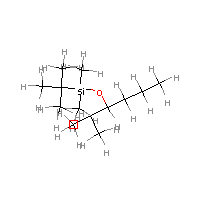

In [5]:
con = Chem.AddHs(mols[list(mols.keys())[2815]])
con

In [6]:
AllChem.EmbedMultipleConfs(con, clearConfs=True, numConfs=50)
opt = AllChem.MMFFOptimizeMoleculeConfs(con)

In [7]:
opt

[(0, 22.76892921051678),
 (0, 18.376920381092486),
 (0, 19.758891189608477),
 (0, 18.37692038719296),
 (0, 21.449627600115793),
 (0, 19.654234885479795),
 (0, 19.220313450312517),
 (1, 17.70757820802174),
 (0, 15.564683185657806),
 (0, 15.86910927709349),
 (0, 18.37692038352144),
 (0, 17.718578026558564),
 (1, 17.702410460394823),
 (0, 19.220313432561404),
 (0, 15.564683184822144),
 (0, 19.533099106730983),
 (1, 15.870248295473651),
 (0, 15.869109288777372),
 (0, 15.869109276890304),
 (1, 18.891564055494122),
 (1, 15.869113853619321),
 (0, 23.561008170480232),
 (1, 21.68851296701341),
 (0, 19.758891190567983),
 (1, 18.881494604892453),
 (0, 19.544748436807073),
 (0, 18.376920398040212),
 (0, 18.371689964654284),
 (0, 19.26718951558301),
 (0, 15.869109297885387),
 (0, 16.488681925985805),
 (0, 20.81344681701515),
 (0, 18.376920385110573),
 (0, 19.656400017870634),
 (0, 18.565093847100986),
 (1, 15.869113923272488),
 (1, 18.893792000921778),
 (1, 18.376922364061983),
 (1, 15.564683192893

In [10]:
drawit(con,confId=30)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [17]:
a = Chem.MolFromSmiles('CCO')
p = Chem.MolFromSmarts('[OH]')
m = a.GetSubstructMatches(p)
a.GetAtomWithIdx(m[0][0]).SetAtomicNum(200)

In [18]:
r = Chem.MolFromSmiles('O[Si]')
p2 = Chem.MolFromSmarts('[#200]')
a, = AllChem.ReplaceSubstructs(a,p2,r)

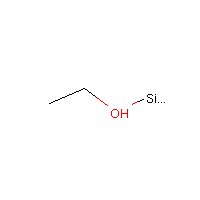

In [19]:
a